### Package import

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn import tree, preprocessing
from sklearn import linear_model, model_selection, metrics, random_projection
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
# from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Data Preprocessing

#### Data Loading

In [2]:
from sqlalchemy import create_engine
my_conn = create_engine("sqlite:///FPA_FOD_20221014.sqlite")

In [3]:
# present all the data 
r_set = my_conn.execute('''select name from sqlite_master where type = 'table' ''')
for row in r_set:
    print(row)

('spatial_ref_sys',)
('spatialite_history',)
('sqlite_sequence',)
('geometry_columns',)
('views_geometry_columns',)
('virts_geometry_columns',)
('geometry_columns_statistics',)
('views_geometry_columns_statistics',)
('virts_geometry_columns_statistics',)
('geometry_columns_field_infos',)
('views_geometry_columns_field_infos',)
('virts_geometry_columns_field_infos',)
('geometry_columns_time',)
('geometry_columns_auth',)
('views_geometry_columns_auth',)
('virts_geometry_columns_auth',)
('sql_statements_log',)
('SpatialIndex',)
('NWCG_UnitIdActive_20200123',)
('Fires',)
('idx_Fires_Shape',)
('idx_Fires_Shape_rowid',)
('idx_Fires_Shape_node',)
('idx_Fires_Shape_parent',)


In [4]:
# select related table 
df_raw = pd.read_sql_query("SELECT FIRE_YEAR, NWCG_GENERAL_CAUSE, LATITUDE, LONGITUDE, STATE, DISCOVERY_DATE, FIRE_SIZE FROM 'Fires'", my_conn)

In [5]:
df_raw.describe()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE
count,2.303566e+06,2.303566e+06,2.303566e+06,2.303566e+06
mean,2.006167e+03,3.696623e+01,-9.635792e+01,7.816088e+01
std,8.044361e+00,6.008260e+00,1.664360e+01,2.630832e+03
min,1.992000e+03,1.793972e+01,-1.788026e+02,1.000000e-05
25%,2.000000e+03,3.301390e+01,-1.110361e+02,1.000000e-01
50%,2.006000e+03,3.572250e+01,-9.347009e+01,8.000000e-01
75%,2.013000e+03,4.089029e+01,-8.251000e+01,3.000000e+00
max,2.020000e+03,7.033060e+01,-6.525694e+01,6.627000e+05


In [6]:
df_raw.head(10)

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2005,Power generation/transmission/distribution,40.036944,-121.005833,CA,2/2/2005,0.10
1,2004,Natural,38.933056,-120.404444,CA,5/12/2004,0.25
2,2004,Debris and open burning,38.984167,-120.735556,CA,5/31/2004,0.10
3,2004,Natural,38.559167,-119.913333,CA,6/28/2004,0.10
4,2004,Natural,38.559167,-119.933056,CA,6/28/2004,0.10
5,2004,Natural,38.635278,-120.103611,CA,6/30/2004,0.10
6,2004,Natural,38.688333,-120.153333,CA,7/1/2004,0.10
7,2005,Debris and open burning,40.968056,-122.433889,CA,3/8/2005,0.80
8,2005,Debris and open burning,41.233611,-122.283333,CA,3/15/2005,1.00
9,2004,Natural,38.548333,-120.149167,CA,7/1/2004,0.10


In [7]:
# reduce number of samples
df_raw = df_raw.sample(n=200000, random_state=10).reset_index(drop=True)

In [8]:
df_raw.head()

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2020,Missing data/not specified/undetermined,30.459444,-88.555000,MS,10/21/2020,5.0
1,2007,Natural,39.635278,-120.219167,CA,7/10/2007,3.0
2,2010,Debris and open burning,31.877464,-98.817796,TX,10/20/2010,1.0
3,1995,Missing data/not specified/undetermined,33.200100,-110.110600,AZ,4/28/1995,0.5
4,1999,Natural,29.660000,-81.320000,FL,8/1/1999,12.0


#### Data Cleaning

In [9]:
# check null value
df_raw.isnull().sum()

FIRE_YEAR             0
NWCG_GENERAL_CAUSE    0
LATITUDE              0
LONGITUDE             0
STATE                 0
DISCOVERY_DATE        0
FIRE_SIZE             0
dtype: int64

In [10]:
# reduce number of classes (cause)
all_causes = set(df_raw['NWCG_GENERAL_CAUSE'])
for c in all_causes:
    print(c)    

# reduce the number of classes of the fire causes
CATEGORY = {}
CATEGORY[1] = ['Natural', 'Debris and open burning']
CATEGORY[2] = ['Arson/incendiarism', 'Smoking', 'Firearms and explosives use', 'Fireworks']
CATEGORY[3] = ['Missing data/not specified/undetermined', ]

def set_label(cause):
    res = 0
    if cause in CATEGORY[1]:
        res = 1
    elif cause in CATEGORY[2]:
        res = 2
    elif cause in CATEGORY[3]:
        res = 3
    else:
        res = 4
    return res

df_raw['LABEL'] = df_raw['NWCG_GENERAL_CAUSE'].apply(lambda c: set_label(c))

Misuse of fire by a minor
Smoking
Arson/incendiarism
Equipment and vehicle use
Other causes
Natural
Recreation and ceremony
Power generation/transmission/distribution
Firearms and explosives use
Railroad operations and maintenance
Debris and open burning
Fireworks
Missing data/not specified/undetermined


In [11]:
df = df_raw.copy()
label = LabelEncoder()

# use label encoder to encode the date information
df['STATE'] = label.fit_transform(df['STATE'])

# extract date information from 'DISCOVERY_DATE' 
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'])
df['DAY_OF_WEEK'] = df['DISCOVERY_DATE'].dt.day_name()
df['DAY_OF_WEEK'] = label.fit_transform(df['DAY_OF_WEEK'])
df['MONTH'] = df['DISCOVERY_DATE'].dt.month
df['DISCOVERY_DATE'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).to_julian_date()
df

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,LABEL,DAY_OF_WEEK,MONTH
0,2020,Missing data/not specified/undetermined,30.459444,-88.555000,25,2459143.5,5.0,3,6,10
1,2007,Natural,39.635278,-120.219167,4,2454291.5,3.0,1,5,7
2,2010,Debris and open burning,31.877464,-98.817796,44,2455489.5,1.0,1,6,10
3,1995,Missing data/not specified/undetermined,33.200100,-110.110600,3,2449835.5,0.5,3,0,4
4,1999,Natural,29.660000,-81.320000,9,2451391.5,12.0,1,3,8
...,...,...,...,...,...,...,...,...,...,...
199995,1997,Natural,44.165000,-118.813333,37,2450657.5,0.1,1,1,7
199996,2003,Debris and open burning,38.918929,-80.539178,50,2452743.5,4.0,1,1,4
199997,2001,Missing data/not specified/undetermined,46.672500,-119.331389,48,2452233.5,19.0,3,5,11
199998,1994,Natural,33.800000,-109.033333,32,2449523.5,0.8,1,1,6


In [12]:
# spliting the dataset
y, X = df['LABEL'], df.drop(['NWCG_GENERAL_CAUSE', 'LABEL'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# standardize the data
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

<AxesSubplot:>

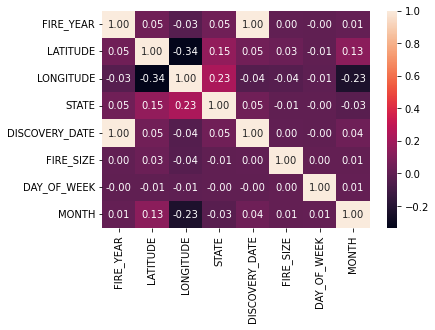

In [13]:
# variable correlation heatmap
X_train_df = pd.DataFrame(data=X_train, columns=['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE', 'DAY_OF_WEEK', 'MONTH'])
sns.heatmap(X_train_df.corr(), annot=True, fmt=".2f")

### Machine Learning Model Training

#### Helper Functions

In [14]:
# draw the confusion matrix
def draw_confusion(model, verbose=False):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    if verbose:
        print("Confusion matrix is", cm)

    cmn = np.round(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], 4)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(cmn, cmap=plt.cm.Blues, alpha=0.8)
    for i in range(cmn.shape[0]):
        for j in range(cmn.shape[1]):
            ax.text(x=j, y=i, s=cmn[i, j], va='center', ha='center')
    plt.xlabel("Predicted Cause Label")
    plt.ylabel("True Cause Label")
    plt.show()

#### Random Forest

In [15]:
clf_rf = RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print("Vannila random forest classification accuracy", clf_rf.score(X_test, y_test))

Vannila random forest classification accuracy 0.5716


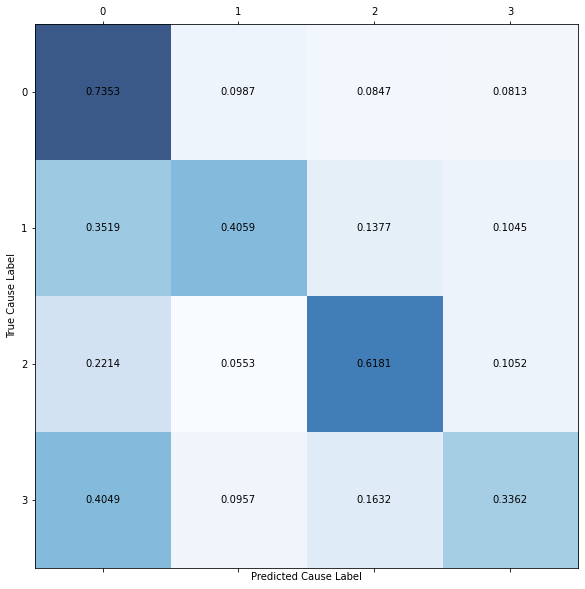

In [16]:
# visualization of each class's accuracy
draw_confusion(clf_rf)

#### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
clf_logit = LogisticRegression(multi_class='ovr', class_weight='balanced', warm_start=True).fit(X_train, y_train)
print("Logistic classification accuracy", clf_logit.score(X_test, y_test))

Logistic classification accuracy 0.30816666666666664


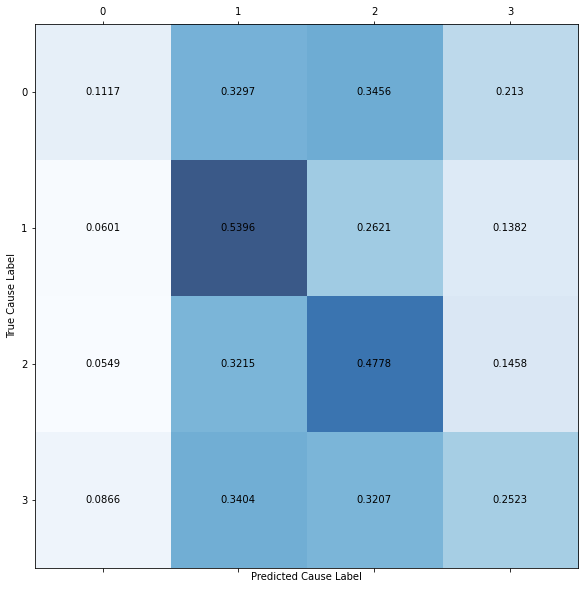

In [18]:
draw_confusion(clf_logit)

#### Gradient Boosting Tree

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gbt = GradientBoostingClassifier().fit(X_train, y_train)
print("Gradient boosting tree accuracy", clf_gbt.score(X_test, y_test))

Gradient boosting tree accuracy 0.5241166666666667


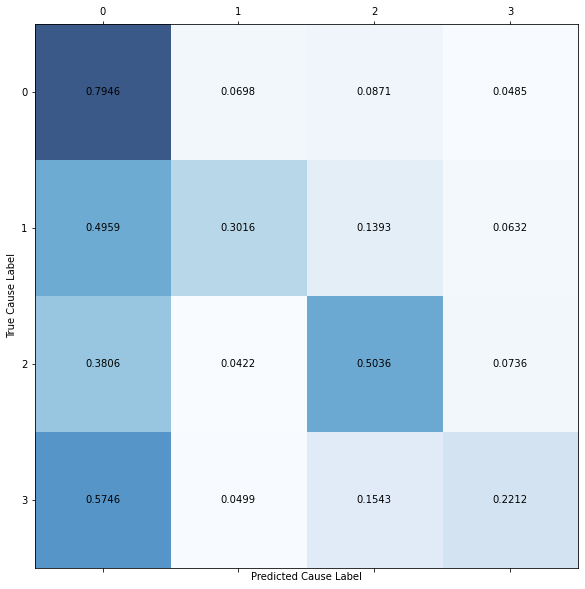

In [20]:
draw_confusion(clf_gbt)

#### Support Vector Machine

In [21]:
from sklearn import svm
clf_svm = svm.LinearSVC()
clf_svm.fit(X_train, y_train)
print("Support vector machine accuracy", clf_svm.score(X_test, y_test))

Support vector machine accuracy 0.3948333333333333


/Users/Yi/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


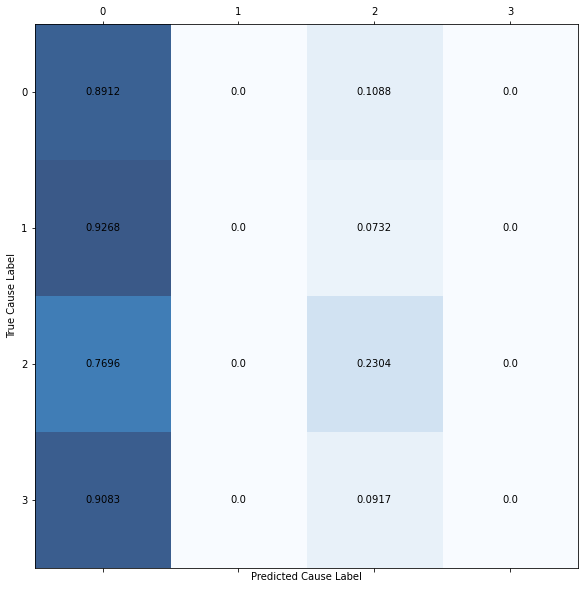

In [22]:
draw_confusion(clf_svm)

The natural cause predition is extremly bad and we might want to further improve the model by using different classification algorithms or proceeding with more carefully preprocessed data or simply by incorporating more relevant features